In [1]:
import numpy as np
import os
import pandas as pd
import json
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
import zlib
import bz2
import tensorflow as tf

2023-01-09 13:29:59.415528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 13:30:01.679434: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/venv/default/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-09 13:30:01.679558: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/venv/defa

In [2]:
parent_folder = '/home/ngsci/project/'
img_folder_path = parent_folder+'save_resnet_embeddings_level4_bags_bracs/'
resnet_pred_folder_path = parent_folder+'save_resnet_pred_level4_bags_bracs/'

In [3]:
os.makedirs(resnet_pred_folder_path, exist_ok=True)

In [4]:
img_bags = np.array( sorted( [ i for i in os.listdir(img_folder_path) if '.npy' in i ] ) )

In [5]:
img_bags[:3], img_bags.shape

(array(['resnet50_bracs_0000459a-838d-4865-8bbf-ea66f2e5ee4d.npy',
        'resnet50_bracs_0001669a-9515-42f2-926b-48f153fd9643.npy',
        'resnet50_bracs_00018c3b-e8c7-49db-9831-7802bde48706.npy'],
       dtype='<U55'),
 (62284,))

In [6]:
backbone = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', pooling='avg')
backbone.trainable = False

def get_model():
    inp = tf.keras.layers.Input(shape=(2048,))
    fc = tf.keras.layers.Dense(128, activation='relu')(inp)
    fc = tf.keras.layers.BatchNormalization()(fc)
    fc = tf.keras.layers.Dropout(0.5)(fc)
    fc = tf.keras.layers.Dense(128, activation='relu')(fc)
    fc = tf.keras.layers.BatchNormalization()(fc)
    fc = tf.keras.layers.Dropout(0.25)(fc)
    out = tf.keras.layers.Dense(7, activation='sigmoid')(fc)
    model = tf.keras.models.Model(inputs=inp, outputs=out)
    
    return model

# https://stackoverflow.com/questions/43702323/how-to-load-only-specific-weights-on-keras

backbone_transfer = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', pooling='avg')
backbone_transfer.trainable = False

def get_model_transfer():
    inp = tf.keras.layers.Input(shape=(224, 224, 3))
    x = tf.keras.applications.resnet50.preprocess_input(inp)
    x = backbone(x)
    x = tf.keras.layers.Flatten()(x)
    fc = tf.keras.layers.Dense(128, activation='relu')(x)
    fc = tf.keras.layers.BatchNormalization()(fc)
    fc = tf.keras.layers.Dropout(0.5)(fc)
    fc = tf.keras.layers.Dense(128, activation='relu')(fc)
    fc = tf.keras.layers.BatchNormalization()(fc)
    fc = tf.keras.layers.Dropout(0.25)(fc)
    out = tf.keras.layers.Dense(7, activation='sigmoid')(fc)
    model = tf.keras.models.Model(inputs=inp, outputs=out)
    
    return model

2023-01-09 13:30:03.299725: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/venv/default/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-09 13:30:03.299765: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-09 13:30:03.299786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-110-15-252.ec2.internal): /proc/driver/nvidia/version does not exist
2023-01-09 13:30:03.299974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable th

In [7]:
weights_folder = './weights_resnet50_bracs/'
weights_name = weights_folder + 'resnet50_epoch_31.hdf5'

In [8]:
model_transfer = get_model_transfer() # fine tuned model on imagenet
model_transfer.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'], optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
model_transfer = tf.keras.models.load_model(weights_name)

In [9]:
to_load_weights = [ i.get_weights() for i in model_transfer.layers[4:] ]
len(to_load_weights)

8

In [10]:
model_transfer.layers[4:]

In [11]:
model = get_model()
model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'], optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

In [12]:
model.layers[1], model.layers[2], model.layers[4], model.layers[5], model.layers[7]

(<keras.layers.core.dense.Dense at 0x7f7e3256e400>,
 <keras.layers.core.dense.Dense at 0x7f7dc405fd00>)

In [13]:
model_transfer.layers[5]

In [14]:
model.layers[1].set_weights(model_transfer.layers[5].get_weights())
model.layers[2].set_weights(model_transfer.layers[6].get_weights())
model.layers[4].set_weights(model_transfer.layers[8].get_weights())
model.layers[5].set_weights(model_transfer.layers[9].get_weights())
model.layers[7].set_weights(model_transfer.layers[11].get_weights())

In [15]:
model.layers[1].get_weights()[0].mean(), model_transfer.layers[5].get_weights()[0].mean()

(0.00014909281, 0.00014909281)

In [16]:
model.layers[7].get_weights()[0].mean(), model_transfer.layers[11].get_weights()[0].mean()

(0.009793838, 0.009793838)

In [17]:
img_folder_path, img_bags[0]

('/home/ngsci/project/save_resnet_embeddings_level4_bags_bracs/',
 'resnet50_bracs_0000459a-838d-4865-8bbf-ea66f2e5ee4d.npy')

In [18]:
current_bag = np.load( img_folder_path+img_bags[0] ).astype(np.float16)

In [25]:
parent_folder = '/home/ngsci/project/'
img_folder_path = '/opt/ngsci/save_resnet_embeddings_level4_bags_bracs/'
resnet_pred_folder_path = '/opt/ngsci/save_resnet_pred_level4_bags_bracs/'

In [26]:
os.makedirs(resnet_pred_folder_path, exist_ok=True)

In [27]:
errors = []
preds = []
for b in tqdm( range(img_bags.shape[0]) ):
    try:
        if not os.path.exists( resnet_pred_folder_path+img_bags[b] ):
            current_bag = np.load( img_folder_path+img_bags[b] ).astype(np.float16)
            resnet_pred = model.predict(x=current_bag, verbose=0)
            preds.append( resnet_pred )
            np.save(resnet_pred_folder_path+img_bags[b], resnet_pred)
    except IndexError:
        print(b, current_bag.shape )
        errors.append( [b, current_bag.shape])

100%|██████████| 62284/62284 [1:15:30<00:00, 13.75it/s]


In [29]:
len(preds)

62284

In [30]:
preds_np = np.concatenate( preds, axis=0 )
preds_np.shape

(25385826, 7)

([<matplotlib.axis.XTick at 0x7f7d7404daf0>,
 [Text(0, 0, 'ADH'),
  Text(1, 0, 'DCIS'),
  Text(2, 0, 'FEA'),
  Text(3, 0, 'INVASIVE-CARCINOMA'),
  Text(4, 0, 'NORMAL'),
  Text(5, 0, 'PATHOLOGICAL-BENIGN'),
  Text(6, 0, 'UDH')])

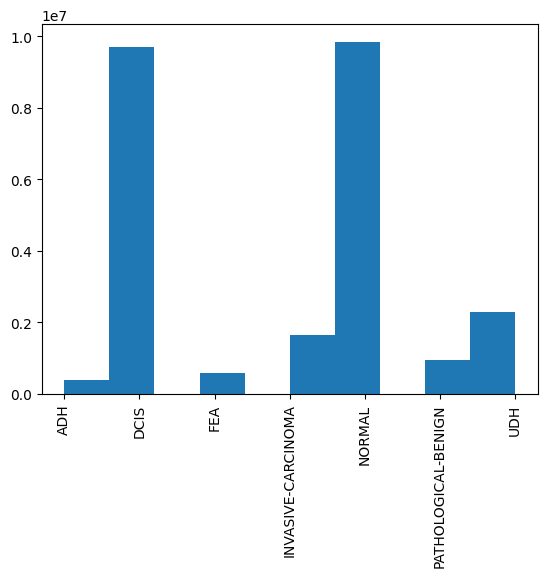

In [44]:
plt.hist( np.argmax( preds_np, axis=1 ) )
plt.xticks( np.arange(7), ['ADH', 'DCIS', 'FEA', 'INVASIVE-CARCINOMA', 'NORMAL',
       'PATHOLOGICAL-BENIGN', 'UDH'], rotation=90 ) 